# Statistical Arbitrage Project
By Quanzhi (Allen) Bi, Zhaohe (Kevin) Huang, Wanyan (Wendy) Shao

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm, skew, kurtosis, ttest_1samp

# Data

Data are downloaded from the [**WRDS**](https://wrds-www.wharton.upenn.edu) (Wharton Research Data Services) database using Python API and web interface. Data from different vendors under WRDS are merged using provided link table. The stock pool is all the constitutes of S&P 500 Index. The time period is from 2007-01-01 to 2020-12-31. It stops at 2020 due to the availability of data in the database. The description of the variables are summarized below. 

| Vendor | Variable | Description |
| :----: | :----: | :----: |
| CRSP - Daily Stock File | prc | daily close price |
| CRSP - Daily Stock File | vol | daily shares of volume |
| CRSP - Daily Stock File | ret | daily holding return |
| CRSP - Beta Suite  | beta | daily market beta of CAPM model using 252-day estimation window |
| Compustat | gsector | GISC sector |

One thing that needs to mention here is the choice of industry classification method. [**GICS**](https://www.msci.com/gics) (The Global Industry Classification Standard) is a four-tiered, hierarchical industry classification system developed by MSCI and S&P Dow Jones Indices. It consists of 11 sectors, 24 industry groups, 69 industries and 158 sub-industries. We choose GICS sector as the industry identifier. **The number of sectors is appropriate. Each sector contains a proper number of companies in the S&P 500 Index, which guarantees sufficient data points in the following regressions to produce reliable results.**  
Another popular industry classification method is [**SIC**](https://en.wikipedia.org/wiki/Standard_Industrial_Classification) (Standard Industrial Classification). The SIC system divides the companies into 83 2-digit major groups. These groups are further subdivided into 416 3-digit industry groups, and finally dis-aggregated into 1005 4-digit industries. Even the number of major groups is too large for our stock pool. It's better to deploy SIC code in larger stock pool like Russell 2000 Index. An alternative methods here is to use custom high-level industry categories based on SIC code, like [**Fama-French 17 industries**](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/det_17_ind_port.html).

In [2]:
# read crsp data
crsp = pd.read_pickle('https://github.com/kevinhzh/stat-arb-project/raw/main/data/crsp.pkl')

# read beta data
beta = pd.read_pickle('https://github.com/kevinhzh/stat-arb-project/raw/main/data/beta.pkl')
beta.set_index(['permno', 'date'], inplace=True)
for permno, permno_df in beta.groupby(level=0):
    beta.loc[(permno, slice(None)), 'beta_lag_1d'] = permno_df['beta'].shift(1)
beta.drop(labels='beta', axis=1, inplace=True)
beta.reset_index(inplace=True)

# merge data
sp500 = crsp.merge(beta, how='left', on=['permno', 'date'])
sp500.sort_values(by=['date', 'permno'], inplace=True)
sp500.set_index(['date', 'permno'], inplace=True)
del crsp, beta

In [3]:
sp500.tail()

prc         vol       ret  gsector  beta_lag_1d
date       permno                                                        
2020-12-31 93089   207.589996    356285.0  0.008796       20       0.9363
           93096   210.300003   1396248.0  0.001763       25       0.4930
           93132   148.529999    482005.0  0.003445       45       1.0287
           93429    93.120003    547634.0  0.005398       40       0.7735
           93436   705.669983  49544141.0  0.015674       25       1.3043

# Generate market_industry neutral stock return

## Run linear factor model

Cross-sectional regressions are run at each date to calculate the market factor return and industry factor return. The formula is as follows.
$$R = \beta_{mkt} F_{mkt} + \beta_{ind_{1}} F_{ind_{1}} + ... + \beta_{ind_{11}} F_{ind_{11}} + \epsilon$$
where $R$ is the return of each stock at date $t$, $\beta_{mkt}$ is the market beta of each stock, and $\beta_{ind_{i}}$ is the industry exposure which takes 1 if a stock belongs to industry $i$ and 0 otherwise. Since all industry exposures add up to ones, there is no need to include the intercept. Note that $\beta_{mkt}$ here is calculated using the data in the past 252 days excluding the date $t$. This is to avoid look-ahead bias and ensure all factor loadings are known before date $t$.  
The coefficients of the regression are the market and industry factor returns. Therefore, the residuals serve as the market-and-industry neutral return. The result is saved as the starting point for the following parts.  
To speed up the calculation, inverse matrix formula is used here to calculate the coefficients of the regression rather than using existed packages.

In [4]:
from tqdm import tqdm

# Run linear factor model cross-sectionally at each date
for date, date_df in tqdm(sp500.groupby(level=0)):
    
    # construct X and y
    X = pd.concat([pd.get_dummies(date_df['gsector']), date_df['beta_lag_1d']], axis=1)
    y = date_df['ret']
    
    # exclude missing values in linear regression
    nan_index = (date_df['beta_lag_1d'].isna() | date_df['ret'].isna())
    X = X.loc[~nan_index].values
    y = y.loc[~nan_index].values
    
    # calculate residuals
    if len(y) > 0:
        params = np.linalg.inv((X.T.dot(X))).dot(X.T).dot(y)
        res = y - X.dot(params)
        date_df.loc[~nan_index, 'neu_ret'] = res
        date_df.loc[nan_index, 'neu_ret'] = np.nan
        sp500.loc[(date, slice(None)), 'neu_ret'] = date_df['neu_ret']
    else:
        sp500.loc[(date, slice(None)), 'neu_ret'] = np.nan

100%|██████████| 3525/3525 [00:52<00:00, 67.73it/s]


In [5]:
sp500.tail()

prc         vol       ret  gsector  beta_lag_1d  \
date       permno                                                           
2020-12-31 93089   207.589996    356285.0  0.008796       20       0.9363   
           93096   210.300003   1396248.0  0.001763       25       0.4930   
           93132   148.529999    482005.0  0.003445       45       1.0287   
           93429    93.120003    547634.0  0.005398       40       0.7735   
           93436   705.669983  49544141.0  0.015674       25       1.3043   

                    neu_ret  
date       permno            
2020-12-31 93089   0.002612  
           93096   0.002214  
           93132  -0.006833  
           93429  -0.009179  
           93436   0.018373

## Calculate aggregated summary statistics

Aggregated summary statistics of $ret$ and $neu\_ret$ are reported below.  
Let's first have a look at the raw returns. $ret$ has a positive mean value because of the bullish market in the past 10 years. The positive skewness might result from the same reason. $ret$ also has a kurtosis larger than 3, indicating the fat-tail feature of its distribution.  
Compared to the raw return, market-and-industry neutral returns show almost zero mean value. This is trivial because of the property of residuals. The volatility of $neu\_ret$ is also smaller. Since the majority of values is concentrated near zero, the kurtosis of $neu\_ret$ is also significantly larger.

In [6]:
agg_stats = pd.DataFrame(sp500[['ret', 'neu_ret']].describe())
for name in ['ret', 'neu_ret']:
    agg_stats.loc['skew', name] = skew(sp500[name], nan_policy='omit')
    agg_stats.loc['kurt', name] = kurtosis(sp500[name], nan_policy='omit')

In [7]:
agg_stats

,ret,neu_ret
count,1.765411e+06,1.759539e+06
mean,4.929028e-04,1.453606e-19
std,2.403430e-02,1.648976e-02
min,-9.424658e-01,-8.634333e-01
25%,-8.708239e-03,-6.193024e-03
50%,5.907682e-04,-1.186642e-04
75%,9.810749e-03,6.008256e-03
max,1.023578e+00,9.223969e-01
skew,5.538470e-01,8.104522e-01
kurt,4.920061e+01,1.061381e+02


## Plot histogram

The histograms further confirm our observations in the descriptive statistics. The distribution of $neu\_ret$ is more centered near zero. The positive skewness and excess kurtosis also indicate that $neu\_ret$ does not follow normal distribution. Therefore, we need to cross-sectionally normalize the momentum factor loadings before we run the regression in the next part.

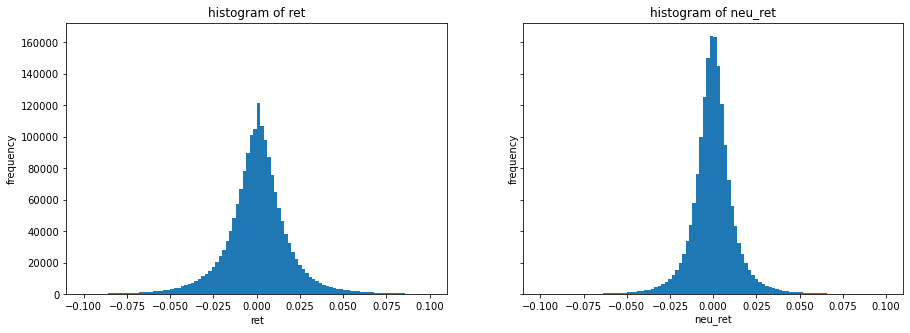

In [8]:
# plot the histogram of ret and neu_ret
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(15, 5))
for i, name in enumerate(['ret', 'neu_ret']):
    axes[i].hist(sp500[name], bins=100, range=(-0.1, 0.1))
    axes[i].set_xlabel(name)
    axes[i].set_ylabel('frequency')
    axes[i].set_title(f'histogram of {name}')
plt.show()

# Build a momentum factor

In [9]:
# read data
sp500 = pd.read_pickle('https://github.com/kevinhzh/stat-arb-project/raw/main/data/sp500.pkl')

## Calculate 1 year trailing market_industry neutral stock returns

The loadings of momentum factor is calculated as the 1 year trailing market-and-industry neutral returns. More specifically, the momentum factor loading of a stock at date $t$ is the cumulative return of market-and-industry neutral returns in the past 252 trading days excluding the date $t$. To have a 1 year trailing return at date $t$, a stock must have returns at date $t-252$ and date $t-1$.

In [10]:
def calc_1Y_ret(arr):
    if (len(arr)!=252) or np.isnan(arr[0]) or np.isnan(arr[-1]):
        return np.nan
    else:
        return np.nanprod(arr + 1) - 1

In [11]:
# set multiindex to make the iteration over stocks easier
sp500.reset_index(inplace=True)
sp500.sort_values(by=['permno', 'date'], inplace=True)
sp500.set_index(['permno', 'date'], inplace=True)

# Calculate 1 year trailing market_industry neutral stock returns
for permno, permno_df in tqdm(sp500.groupby(level=0)):
    neu_ret_mom_df = permno_df['neu_ret'].rolling(window=252, min_periods=2, closed='left').apply(func=calc_1Y_ret, raw=True)
    sp500.loc[(permno, slice(None)), 'neu_ret_mom'] = neu_ret_mom_df

# recover the multiindex
sp500.reset_index(inplace=True)
sp500.sort_values(by=['date', 'permno'], inplace=True)
sp500.set_index(['date', 'permno'], inplace=True)

100%|██████████| 831/831 [00:27<00:00, 30.06it/s]


In [12]:
sp500.tail()

prc         vol       ret  gsector  beta_lag_1d  \
date       permno                                                           
2020-12-31 93089   207.589996    356285.0  0.008796       20       0.9363   
           93096   210.300003   1396248.0  0.001763       25       0.4930   
           93132   148.529999    482005.0  0.003445       45       1.0287   
           93429    93.120003    547634.0  0.005398       40       0.7735   
           93436   705.669983  49544141.0  0.015674       25       1.3043   

                    neu_ret  neu_ret_mom  
date       permno                         
2020-12-31 93089   0.002612     0.098867  
           93096   0.002214     0.424564  
           93132  -0.006833     0.125918  
           93429  -0.009179    -0.284247  
           93436   0.018373          NaN

## Cross-sectional normalization

To avoid extremely fat-tailed data, cross-sectional normalization is necessary before regression.  
Normalization refers to a robust procedure by which the data is converted to ranks and passed through the inverse CDF of a standard normal distribution. It preserves the order, but reshapes the data to appear normally distributed.

In [13]:
# Cross-sectional normalization
for date, date_df in tqdm(sp500.groupby(level=0)):
    neu_ret_mom_rank = date_df['neu_ret_mom'].rank(method='dense')
    neu_ret_mom_rank = neu_ret_mom_rank / (neu_ret_mom_rank.max() + 1) # avoid converting 1 into inf
    sp500.loc[(date, slice(None)), 'beta_mom_lag_1d'] = norm.ppf(neu_ret_mom_rank)

100%|██████████| 3525/3525 [00:38<00:00, 91.77it/s]


In [14]:
sp500.tail()

prc         vol       ret  gsector  beta_lag_1d  \
date       permno                                                           
2020-12-31 93089   207.589996    356285.0  0.008796       20       0.9363   
           93096   210.300003   1396248.0  0.001763       25       0.4930   
           93132   148.529999    482005.0  0.003445       45       1.0287   
           93429    93.120003    547634.0  0.005398       40       0.7735   
           93436   705.669983  49544141.0  0.015674       25       1.3043   

                    neu_ret  neu_ret_mom  beta_mom_lag_1d  
date       permno                                          
2020-12-31 93089   0.002612     0.098867         0.671256  
           93096   0.002214     0.424564         1.460936  
           93132  -0.006833     0.125918         0.757818  
           93429  -0.009179    -0.284247        -1.300541  
           93436   0.018373          NaN              NaN

## Compute the daily momentum factor return

Cross-sectional regressions are run at each date to calculate the momentum factor return.
$$R = \beta_{mkt} F_{mkt} + \beta_{ind_{1}} F_{ind_{1}} + ... + \beta_{ind_{11}} F_{ind_{11}} + \beta_{mom} F_{mom} + \epsilon$$
where $\beta_{mom}$ is the cross-sectionally normalized 1 year trailing market_industry neutral stock returns.   
The coefficients of the regression are the market, industry and momentum factor returns. Therefore, running cross-sectional regression at each date gives us the time series of the daily momentum factor returns.

In [15]:
# Run linear factor model cross-sectionally on each date
mom_ret = pd.DataFrame(columns=['mom_ret'], dtype=float)
for date, date_df in tqdm(sp500.groupby(level=0)):
    
    # construct X and y
    X = pd.concat([pd.get_dummies(date_df['gsector']), date_df[['beta_lag_1d', 'beta_mom_lag_1d']]], axis=1)
    y = date_df['ret']
    
    # exclude missing values in linear regression
    nan_index = (date_df['beta_lag_1d'].isna() | date_df['beta_mom_lag_1d'].isna() | date_df['ret'].isna())
    X = X.loc[~nan_index].values
    y = y.loc[~nan_index].values
    
    # calculate momentum factor return
    if len(y) > 0:
        params = np.linalg.inv((X.T.dot(X))).dot(X.T).dot(y)
        mom_ret.loc[date, 'mom_ret'] = params[-1]

100%|██████████| 3525/3525 [00:05<00:00, 678.65it/s]


In [16]:
mom_ret

,mom_ret
2008-01-04,0.002849
2008-01-07,-0.000836
2008-01-08,0.006970
2008-01-09,0.003711
2008-01-10,-0.009854
...,...
2020-12-24,0.000299
2020-12-28,-0.003276
2020-12-29,0.000353
2020-12-30,0.000601


## Create a daily rebalanced factor-mimicking portfolio

To create a daily rebalanced factor-mimicking portfolio, we assign stock positions proportionally to the scaled factor loadings. The scaler is chosen to be the sum of the absolute values of factor loadings, making the sum of the absolute values of stock positions add up to 1. Since the factor loadings has zero mean, the factor-mimicking portfolio is actually a zero-cost long-short portfolio.

In [17]:
# Create a daily rebalanced factor-mimicking portfolio
mom_port_ret = pd.DataFrame(columns=['mom_port_ret'], dtype=float)
for date, date_df in tqdm(sp500.groupby(level=0)):
    if (~date_df['beta_mom_lag_1d'].isna()).sum() > 0:
        s = 1 / np.nansum(np.abs(date_df['beta_mom_lag_1d'])) # scaler
        mom_port_ret.loc[date, 'mom_port_ret'] = np.nansum(date_df['ret'] * date_df['beta_mom_lag_1d']) * s

100%|██████████| 3525/3525 [00:01<00:00, 2280.46it/s]


In [18]:
mom_port_ret

,mom_port_ret
2008-01-04,0.004340
2008-01-07,-0.000400
2008-01-08,0.009247
2008-01-09,0.004966
2008-01-10,-0.013225
...,...
2020-12-24,0.001133
2020-12-28,-0.004082
2020-12-29,0.000950
2020-12-30,-0.001829


## Plot the daily return

From the plots, we can see that the daily momentum factor return and factor-mimicking portfolio return show very similar patterns. The correlation coefficient of momentum factor return and factor-mimicking portfolio return is 0.963. They helps verify the effectiveness of "factor-mimicking". More detailed analysis will be conducted in the next part.

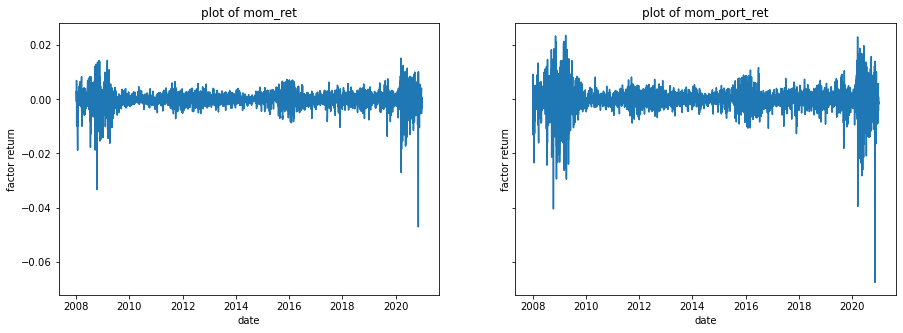

In [19]:
# plot the daily momentum factor return and factor-mimicking portfolio return
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(15, 5))
for i, df in enumerate([mom_ret, mom_port_ret]):
    axes[i].plot(df)
    axes[i].set_xlabel('date')
    axes[i].set_ylabel('factor return')
    axes[i].set_title(f'plot of {df.columns[0]}')
plt.show()

In [20]:
rho = np.corrcoef(mom_ret['mom_ret'], mom_port_ret['mom_port_ret'])[0][1]
print(f'The correlation coefficient of factor return and factor-mimicking portfolio return is {rho:.3f}.')

The correlation coefficient of factor return and factor-mimicking portfolio return is 0.963.


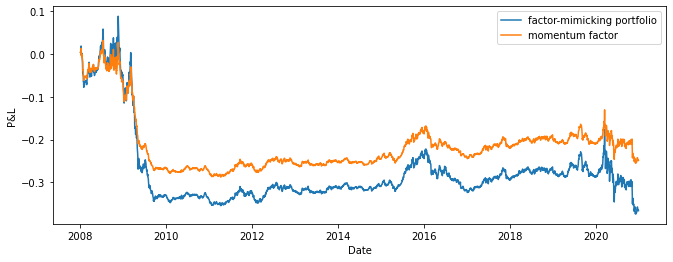

In [21]:
fig, ax = plt.subplots(figsize=(11,4))
ax.plot(np.cumprod(mom_port_ret+1)-1, label='factor-mimicking portfolio')
ax.plot(np.cumprod(mom_ret+1)-1, label='momentum factor')
ax.set_xlabel('Date')
ax.set_ylabel('P&L')
ax.legend(loc='best')

In [22]:
mom_port_ret.to_csv('mom.csv')

## Analyze the historical performance

We calculated a series of metrics to evaluate the historical performance of the momentum factor-mimicking portfolio returns. The result shows that it did not perform very well in the past ten years. The portfolio achieved a daily return of -0.01% on average, which is not significantly different from zero. The Sharpe ratio is also negative, which is -0.44. The max drawdown of 42.38% is also very high. All of these metrics show low returns and high risk of the market-and-industry neutral factor.  
Compared to the classical "raw" momentum factor, the weak performance of market-and-industry neutral stock return indicates that the abnormal return of the classical "raw" momentum factor might be largely attributed to the market momentum and the industry momentum. The result aligns with the conclusion of [Moskowitz and Grinblatt (1999)](https://doi.org/10.1111/0022-1082.00146).

In [23]:
def backtest_evaluation(port_ret):
    metric = pd.DataFrame(index=['factor-mimicking portfolio'],
                          columns=['mean daily ret', 't value', 'p value',
                                   'annualized ret', 'annualized vol',
                                   'Sharpe ratio', 'Win ratio', 'Max drawdown'])
    metric.loc['factor-mimicking portfolio', 'mean daily ret'] = port_ret.mean()
    t_value, p_value = ttest_1samp(port_ret, popmean=0)
    metric.loc['factor-mimicking portfolio', 't value'] = t_value
    metric.loc['factor-mimicking portfolio', 'p value'] = p_value
    annualized_ret = np.prod(port_ret+1)**(252/len(port_ret))-1
    metric.loc['factor-mimicking portfolio', 'annualized ret'] = annualized_ret
    annualized_vol = port_ret.std() * np.sqrt(252)
    metric.loc['factor-mimicking portfolio', 'annualized vol'] = annualized_vol
    metric.loc['factor-mimicking portfolio', 'Sharpe ratio'] = annualized_ret / annualized_vol
    metric.loc['factor-mimicking portfolio', 'Win ratio'] = (port_ret > 0).sum() / len(port_ret)
    curr, pre_high, max_drawdown = 1, 1, 0
    for ret in port_ret:
        curr *= (ret + 1)
        max_drawdown = max(max_drawdown, (pre_high - curr) / pre_high)
        pre_high = max(pre_high, curr)
    metric.loc['factor-mimicking portfolio', 'Max drawdown'] = max_drawdown
    return metric

In [24]:
backtest_evaluation(mom_port_ret['mom_port_ret'])

,mean daily ret,t value,p value,annualized ret,annualized vol,Sharpe ratio,Win ratio,Max drawdown
factor-mimicking portfolio,-0.000127,-1.460198,0.144332,-0.034463,0.078828,-0.437192,0.510697,0.423847


## Does 1 month reversal matter?

1 month reversal is another famous anomaly. The classical monthly momentum also excludes the stock returns in the most recent month. Therefore, we explored that whether excluding the most recent month can improve the performance of the market-and-industry momentum factor. The data processing details refer to [Fama-Frech daily momentum factor](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/det_mom_factor_daily.html). To have a 1 year trailing return excluding the most recent month at date $t$, a stock must have returns at date $t-252$ and date $t-21$.

In [25]:
def calc_12M_1M_ret(arr):
    if (len(arr)!=252) or np.isnan(arr[0]) or np.isnan(arr[-21]):
        return np.nan
    else:
        return np.nanprod(arr[:-20] + 1) - 1

In [26]:
# set multiindex to make the iteration over stocks easier
sp500.reset_index(inplace=True)
sp500.sort_values(by=['permno', 'date'], inplace=True)
sp500.set_index(['permno', 'date'], inplace=True)

# Calculate trailing market_industry neutral stock returns in the past 12-1 months
for permno, permno_df in tqdm(sp500.groupby(level=0)):
    neu_ret_mom2_df = permno_df['neu_ret'].rolling(window=252, min_periods=2, closed='left').apply(func=calc_12M_1M_ret, raw=True)
    sp500.loc[(permno, slice(None)), 'neu_ret_mom2'] = neu_ret_mom2_df

# recover the multiindex
sp500.reset_index(inplace=True)
sp500.sort_values(by=['date', 'permno'], inplace=True)
sp500.set_index(['date', 'permno'], inplace=True)

100%|██████████| 831/831 [00:28<00:00, 29.60it/s]


In [27]:
# Cross-sectional normalization
for date, date_df in tqdm(sp500.groupby(level=0)):
    neu_ret_mom2_rank = date_df['neu_ret_mom2'].rank(method='dense')
    neu_ret_mom2_rank = neu_ret_mom2_rank / (neu_ret_mom2_rank.max() + 1) # avoid converting 1 into inf
    sp500.loc[(date, slice(None)), 'beta_mom2_lag_1d'] = norm.ppf(neu_ret_mom2_rank)

100%|██████████| 3525/3525 [00:39<00:00, 88.18it/s]


In [28]:
# Create a daily rebalanced factor-mimicking portfolio
mom2_port_ret = pd.DataFrame(columns=['mom2_port_ret'], dtype=float)
for date, date_df in tqdm(sp500.groupby(level=0)):
    if (~date_df['beta_mom2_lag_1d'].isna()).sum() > 0:
        s = 1 / np.nansum(np.abs(date_df['beta_mom2_lag_1d'])) # scaler
        mom2_port_ret.loc[date, 'mom2_port_ret'] = np.nansum(date_df['ret'] * date_df['beta_mom2_lag_1d']) * s

100%|██████████| 3525/3525 [00:01<00:00, 2192.64it/s]


In [29]:
mom2_port_ret

,mom2_port_ret
2008-01-04,0.004023
2008-01-07,-0.000184
2008-01-08,0.009240
2008-01-09,0.004986
2008-01-10,-0.012265
...,...
2020-12-24,0.001409
2020-12-28,-0.003935
2020-12-29,0.001284
2020-12-30,-0.002028


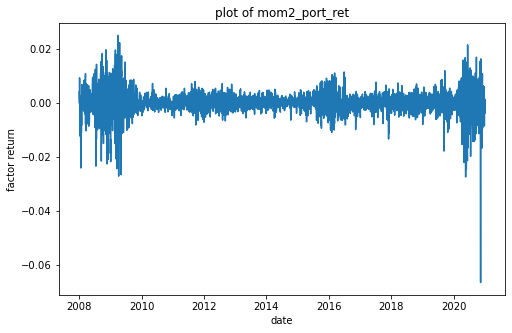

In [30]:
# plot the factor-mimicking portfolio return
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(8, 5))
ax.plot(mom2_port_ret['mom2_port_ret'])
ax.set_xlabel('date')
ax.set_ylabel('factor return')
ax.set_title(f'plot of mom2_port_ret')
plt.show()

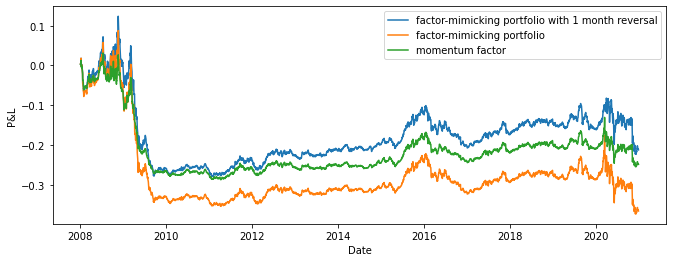

In [31]:
fig, ax = plt.subplots(figsize=(11,4))
ax.plot(np.cumprod(1+mom2_port_ret)-1, label='factor-mimicking portfolio with 1 month reversal')
ax.plot(np.cumprod(1+mom_port_ret)-1, label='factor-mimicking portfolio')
ax.plot(np.cumprod(1+mom_ret)-1, label='momentum factor')
ax.set_xlabel('Date')
ax.set_ylabel('P&L')
ax.legend(loc='best')

In [32]:
backtest_evaluation(mom2_port_ret['mom2_port_ret'])

,mean daily ret,t value,p value,annualized ret,annualized vol,Sharpe ratio,Win ratio,Max drawdown
factor-mimicking portfolio,-0.000063,-0.792809,0.427946,-0.018202,0.07174,-0.253728,0.517115,0.358822


Examining the performance metrics, we can see that excluding 1 month reversal increases the annualized return, decreases the annualized volatility, and thus increase the Sharpe ratio. The max drawdown also improves. However, the overall performance of the market-and-industry neutral momentum factor is still not good. The Sharpe ratio remains negative.

# Trading signal design

In this section we are going to build ML model to predict the market-industry-neutural return of each stock separately.

$$
\hat{\epsilon}_t = f(g(x))
$$

where 

- $f(\cdot)$ is the ML regression model of our choice, we tried linear models and xgboost
- $x=\{x_{t}, x_{t-1},...\}$ is the historical price and volume data of the stock of interest
- $g(x)$ is the feature transformation function, including feature extraction, imputation, scaling and decomposition.

Then we're going to use the predicted $\epsilon_t$ to adjust the portfolio based on mean-variance optimization.

In [33]:
import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS, PooledOLS, FamaMacBeth
from sklearn.metrics import r2_score
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from tqdm import tqdm
import talib

## Prepare the data

We first download the data from our github repo, drop the duplicated rows and reset the index so we can further manipulate the index later

In [34]:
sp500 = pd.read_pickle(
    'https://github.com/kevinhzh/stat-arb-project/raw/main/data/sp500.pkl')
sp500.drop_duplicates(inplace=True)
sp500.reset_index(inplace=True)

Since S&P 500 adjusts the company list constantly, in this section we only select the stocks that exists throughout the entire period of study (`2007-2020`), 3525 days in total.

In [35]:
len_list = []
for permno, df in sp500.groupby('permno'):
    if len(df) == 6126:
        print(permno, df)
    len_list.append(len(df))
    
print(max(len_list))

3525


The cell below shows that our stock universe contains 262 stocks.

In [36]:
permno_list = []
for permno, df in sp500.groupby('permno'):
    if (len(df) == 3525) and (df['date'].iloc[-1] == pd.to_datetime('2020-12-31')):
        permno_list.append(permno)
print(len(permno_list))

262


In [37]:
spdata = sp500[sp500['permno'].isin(permno_list)]

## Feature Extraction

Now we need extraction from the original price-volume dataset. To maintein open-closed principle (open for extension, but closed for modification, OCP), we used scikit-learn's idea of pipeline. Each feature extraction is now a transformer object in the pipeline. It adds a new column of new feature to the input dataframe. The structure of the pipeline is shown below:

```bash
X, y -> FeatureTransformer1
     -> FeatureTransformer2
     -> ...
     -> FeatureTransformerk
     -> Imputer
     -> StandardScaler
     -> PCA ?
     -> Regressor
```

For the detail of each feature, see the docstring of each transformer class.

In [38]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
import xgboost as xgb

class MomentumFeature(BaseEstimator, TransformerMixin):

    '''

    Momentum Feature Transformer

    Calculate the momentum of the asset based on the historical returns

        mom = rt + rt-1 + ... + rt-w

    Parameters
    ----------
    window: int
        the window size we used to compute the momentum


    '''

    def __init__(self, window):
        self.window = window * 20

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):

        def calc_ret(arr):
            if (len(arr) != self.window) or np.isnan(arr[0]) or np.isnan(arr[-1]):
                return np.nan
            else:
                return np.nanprod(arr + 1) - 1

        ret_mom_df = X['ret'].rolling(
            window=self.window, min_periods=2, closed='left').apply(func=calc_ret, raw=True)
        ret_mom_df.name = 'mom_ret_{:d}M'.format(int(self.window/20))
        return pd.concat([X, ret_mom_df], axis=1)


class RSIFeature(BaseEstimator, TransformerMixin):

    '''

    Relative Strength Index Feature Transformer
    
    RSI = 100 - 100 / (1+RS)

    See https://en.wikipedia.org/wiki/Relative_strength_index
    
    Parameters
    ----------
    window: int
        the window size we used to compute the RSI


    '''

    def __init__(self, window=14):
        self.window = window

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):

        rsi_df = talib.RSI(X['ret'], timeperiod=self.window)
        rsi_df.name = 'RSI'
        return pd.concat([X, rsi_df], axis=1)
    
class EMAFeature(BaseEstimator, TransformerMixin):
    '''
    Exponential Moving Average Feature Transformer
    
    EMAt = EMAt-1 + a * (rt - EMAt)
    
    See https://en.wikipedia.org/wiki/Moving_average#Exponentially_weighted_moving_variance_and_standard_deviation
    
    Parameters
    ----------
    timeperiod: int
        the window size
        
    '''
    
    def __init__(self, timeperiod=30):
        self.timeperiod = timeperiod

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):

        ema_df = talib.EMA(X['ret'], timeperiod=self.timeperiod)
        ema_df.name = 'EMA_{:d}'.format(self.timeperiod)
        return pd.concat([X, ema_df], axis=1)
    
class OBVFeature(BaseEstimator, TransformerMixin):
    '''
    On Balance Volume Feature Transformer   
    
    OBVt = OBVt-1 + Vt * sign(rt)
    
    See https://en.wikipedia.org/wiki/On-balance_volume
    '''
    
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):

        obv_df = talib.OBV(X['ret'].cumsum(), X['vol'])
        obv_df.name = 'OBV'
        return pd.concat([X, obv_df], axis=1)
    
class VolatilityFeature(BaseEstimator, TransformerMixin):
    '''
    Rolling Volatility Feature Transformer
    
    Estimated by rolling standard deviation
    
    Parameters
    ----------
    timeperiod: int
        the window size
    '''
    
    def __init__(self, timeperiod=30):
        self.timeperiod = timeperiod

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):

        vol_df = X['ret'].rolling(window=self.timeperiod).std()
        vol_df.name = 'Volatility_{:d}'.format(self.timeperiod)
        return pd.concat([X, vol_df], axis=1)
    
class SmartMoneyFeature(BaseEstimator, TransformerMixin):
    '''
    Modified Smart Money Feature Transformer
    
    SMt = max_{t-w}^t |Ri| / sqrt(Vt)
    
    Explaination: Small volume with large return might be made by a smart trader
    
    Parameters
    ----------
    timeperiod: int
        the window size
    '''
    
    def __init__(self, timeperiod=10):
        self.timeperiod = timeperiod

    def fit(self, X, y=None):
        
        return self

    def transform(self, X, y=None):

        sm_df = X['ret'].abs().rolling(self.timeperiod).max() / np.sqrt(1+X['vol'].fillna(value=0, inplace=False))
        sm_df.name = 'SM'
        return pd.concat([X, sm_df], axis=1)

## Use different ML models

In order to try different machine learing models without modifying too much code, we used scikit-learn's API of different machine learning models as the end of our ML pipeline. We chose the following models since they are popular, explainable and fast to train.

- Linear Regression
- Ridge Regression
- Lasso Regression
- XGBoost Regressor

In [39]:
def fit_predict(spdata, regressor_pipe):
    '''
    Fit the training data and predict on the test data
    
    Parameters
    ----------
    spdata: dataframe
        the price-volume dataset of each stock on each date
        
    regressor_pipe: list of tuple (name, transformer/estimator)
        a list containing the pipeline we need for the ML model
        for example some model might need a PCA before training
        while the others doesn't need. So we maintain the 
        flexibility. Again if we want to add/remove some features
        as can also insert our own transformer into the regressor_pipe
        
    Returns
    ---------
    predicted_results: dataframe
        Datafreame containing the origial target, predicted target, aligned 
        by the index
    
    '''

    predicted_results = pd.DataFrame()

    for permno, permno_df in tqdm(spdata.groupby('permno')):

        X = permno_df.set_index('date')[['vol', 'ret']]
        y = permno_df.set_index('date')['neu_ret'].shift(
            periods=-1).fillna(value=0)

        X_train, X_test = X[:'2016-01-01'], X['2016-01-01':'2020-12-31']
        # '2020-12-31'
        y_train, y_test = y[:'2016-01-01'], y['2016-01-01':'2020-12-31']

        # pipeline steps in our model
        steps = []

        # add some momentum features into our data
        for i in range(1, 25):
            name = 'mom {:d}M'.format(i)
            steps.append((name, MomentumFeature(window=i)))

        # we can add more technical indicators as features
        # RSI
        steps.append(('RSI', RSIFeature()))
        # EMA
        steps.append(('EMA', EMAFeature()))
        # OBV
        steps.append(('OBV', OBVFeature()))
        # Volatility
        steps.append(('Volatility', VolatilityFeature()))
        # Smart Money
        steps.append(('SM', SmartMoneyFeature()))
        
        # impute the missing value by th median of the training set
        steps.append(('imputer', SimpleImputer(strategy='median')))
        # standard scaling (mean=0, std=1)
        steps.append(('scaler', StandardScaler()))
        
        # add the regressor steps from the regressor pipeline
        for step in regressor_pipe:
            steps.append(step)

        pipe = Pipeline(steps)
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)

        temp = pd.concat([pd.DataFrame(y_test.index),
                          pd.DataFrame(y_pred)], axis=1)
        temp.columns = ['date', 'neu_ret_pred']
        temp['neu_ret_pred'] = temp['neu_ret_pred'].shift(1)
        temp['permno'] = permno
        predicted_results = pd.concat([predicted_results, temp])

    predicted_results.set_index(['date', 'permno'], inplace=True)
    ret = pd.concat([spdata.loc[:, ['date', 'permno', 'neu_ret']].set_index(
        ['date', 'permno']), predicted_results], join='inner', axis=1)
    ret.dropna(inplace=True)
    return ret


## Model Performance Measure

After we have the predicted return $\hat{\epsilon}_{j, t}$ for stock $j$ on date $t$, we can run a panel regression with intercept to see the performance.

$$
\epsilon_{j, t} = \beta_0 + \beta_1 \hat{\epsilon}_{j, t}
$$

We used `linearmodels`'s implementation of panel regression. Notice that using `cov_type = 'kernel'` will give us the newey-west adjusted t statistics ([doc](https://bashtage.github.io/linearmodels/panel/panel/linearmodels.panel.model.PanelOLS.fit.html#linearmodels.panel.model.PanelOLS.fit)).

In [40]:
def model_performance(true_y, predicted_y, mode='PanelOLS', verbose=False):
    # choose certain panel regression method to compare the predicted signal and true signal

    exog = sm.add_constant(predicted_y)
    dependent = true_y
    if mode == 'RandomEffects':
        mod = RandomEffects(dependent, exog)
    else:
        mod = PanelOLS(dependent, exog)
    # use covariance type = 'kernel' similar to the newey-west cov matrix (doc)
    model = mod.fit(cov_type='kernel')
    if verbose:
        print(model)  # see newey-west t-statistics from the summary
    predicted_results = model.predict(exog=exog)
    return r2_score(true_y, predicted_results)

As we can see xgboost model beats the linear models in both the r-squared (1 bp vs 0.1 bp) as well as the t-stat inference (`p-value` < 0.05). Note that we used PCA in both the linear model and the penalized linear model to avoid the multicollinearity.

In [41]:
predicted_results = fit_predict(spdata, regressor_pipe=[('pca', PCA(n_components='mle', random_state=42)), 
                                                        ('lm', LinearRegression())])
model_performance(predicted_results.neu_ret,
                  predicted_results.neu_ret_pred, mode='PanelOLS', verbose=True);

100%|██████████| 262/262 [02:35<00:00,  1.68it/s]


                          PanelOLS Estimation Summary                           
Dep. Variable:                neu_ret   R-squared:                     3.641e-05
Estimator:                   PanelOLS   R-squared (Between):              0.0006
No. Observations:              329596   R-squared (Within):             3.42e-05
Date:                Sun, Apr 04 2021   R-squared (Overall):           3.641e-05
Time:                        13:50:19   Log-likelihood                 9.507e+05
Cov. Estimator:        Driscoll-Kraay                                           
                                        F-statistic:                      12.000
Entities:                        1259   P-value                           0.0005
Avg Obs:                       261.79   Distribution:                F(1,329594)
Min Obs:                       0.0000                                           
Max Obs:                       262.00   F-statistic (robust):             2.6562
                            

In [42]:
predicted_results = fit_predict(spdata, regressor_pipe=[('pca', PCA(n_components='mle', random_state=42)),
                                                        ('ridge', Ridge(alpha=10))])
model_performance(predicted_results.neu_ret,
                  predicted_results.neu_ret_pred, mode='PanelOLS', verbose=True);

100%|██████████| 262/262 [02:35<00:00,  1.68it/s]


                          PanelOLS Estimation Summary                           
Dep. Variable:                neu_ret   R-squared:                     3.708e-05
Estimator:                   PanelOLS   R-squared (Between):              0.0006
No. Observations:              329596   R-squared (Within):            3.477e-05
Date:                Sun, Apr 04 2021   R-squared (Overall):           3.708e-05
Time:                        13:52:59   Log-likelihood                 9.507e+05
Cov. Estimator:        Driscoll-Kraay                                           
                                        F-statistic:                      12.221
Entities:                        1259   P-value                           0.0005
Avg Obs:                       261.79   Distribution:                F(1,329594)
Min Obs:                       0.0000                                           
Max Obs:                       262.00   F-statistic (robust):             2.7475
                            

In [43]:
predicted_results = fit_predict(spdata, regressor_pipe=[('pca', PCA(n_components='mle', random_state=42)),
                                                        ('lasso', Lasso(alpha=10))])
model_performance(predicted_results.neu_ret,
                  predicted_results.neu_ret_pred, mode='PanelOLS', verbose=True);

100%|██████████| 262/262 [02:35<00:00,  1.68it/s]


                          PanelOLS Estimation Summary                           
Dep. Variable:                neu_ret   R-squared:                     8.017e-06
Estimator:                   PanelOLS   R-squared (Between):              0.0000
No. Observations:              329596   R-squared (Within):            8.047e-06
Date:                Sun, Apr 04 2021   R-squared (Overall):           8.017e-06
Time:                        13:55:39   Log-likelihood                 9.507e+05
Cov. Estimator:        Driscoll-Kraay                                           
                                        F-statistic:                      2.6422
Entities:                        1259   P-value                           0.1041
Avg Obs:                       261.79   Distribution:                F(1,329594)
Min Obs:                       0.0000                                           
Max Obs:                       262.00   F-statistic (robust):             1.6237
                            

In [44]:
xgb_reg = xgb.XGBRegressor(learning_rate=0.05, reg_lambda=4, colsample_bytree=0.6, random_state=42)
predicted_results = fit_predict(spdata, regressor_pipe=[('xgb', xgb_reg)])
r2 = model_performance(predicted_results.neu_ret,
                       predicted_results.neu_ret_pred, mode='PanelOLS', verbose=True)
print('r-squared = {:.6f}'.format(r2))

100%|██████████| 262/262 [02:57<00:00,  1.48it/s]


                          PanelOLS Estimation Summary                           
Dep. Variable:                neu_ret   R-squared:                        0.0001
Estimator:                   PanelOLS   R-squared (Between):             -0.0083
No. Observations:              329596   R-squared (Within):               0.0002
Date:                Sun, Apr 04 2021   R-squared (Overall):              0.0001
Time:                        13:58:41   Log-likelihood                 9.507e+05
Cov. Estimator:        Driscoll-Kraay                                           
                                        F-statistic:                      43.849
Entities:                        1259   P-value                           0.0000
Avg Obs:                       261.79   Distribution:                F(1,329594)
Min Obs:                       0.0000                                           
Max Obs:                       262.00   F-statistic (robust):             15.976
                            

## Mean Variance Optimization

Finally we're going to apply the mean-variance optimzation to construct the portfolio based on our prediction. Everyday $t$ the optimization problem is as follows

$$
\begin{aligned}
    \min_\omega & & \omega^T \Omega_t \omega \\
    \mathrm{s.t.} & & \omega^T\mu_t = a\\
                 & & \omega^T \iota = 1\\
\end{aligned}
$$

where $\omega$ is the dollar holding of the portfolio, $\Omega_t$ is the covariance matrix that we estimated, $\mu_t$ is the expected return of the portfolio. Here we use $\mu = \hat{\epsilon_{t+1}}$, lastly we require the holding is normalized $\iota = (1,1,...,1)^T$.

We may solve the problem to obtain the optimal choice of the weights:

$$
\omega = v_1 + a v_2
$$

where

$$
\begin{aligned}
    v_1 &= \frac{1}{D} [B\Omega_t^{-1}\iota - A\Omega_t^{-1}\mu_t]\\
    v_2 &= \frac{1}{D} [C\Omega_t^{-1}\mu - A\Omega_t^{-1}\iota]\\
\end{aligned}
$$

$A = \iota^T\Omega_t^{-1}\mu, B=\mu^T\Omega_t^{-1}\mu, C=\iota^T\Omega^{-1}_t\iota, D=BC-A^2$

In [45]:
sorted_dates = pd.to_datetime(np.sort(pd.unique(spdata.date)))
sorted_dates = sorted_dates.to_frame().reset_index(drop=True)
sorted_dates.columns = ['date']

In [46]:
def cov_cal(date, delta_t, sorted_dates=sorted_dates):
    '''
    estimate the covariance matrix by sample covariance
    '''
    start_day_index = sorted_dates[sorted_dates['date']
                                   == date].index.values[0]
    temp = pd.DataFrame()
    col_name = []
    for permno, permno_df in spdata.groupby('permno'):
        permno_df.reset_index(inplace=True)
        permno_df.set_index('date', inplace=True)
        temp_df = permno_df.loc[:, 'neu_ret']
        temp_df = temp_df.iloc[(start_day_index - delta_t+1):(start_day_index+1)]
        col_name.append(permno)
        temp = pd.concat([temp, temp_df], axis=1)
    temp.columns = col_name
    return temp.cov()

In [49]:
def mean_variance_opt(mu, sigma, expected_ret):
    '''
    Mean Variance Optimization
    
    Parameters
    ----------
    mu: array like
        the cross-sectional expected return
        
    sigma : matrix like
        the cross-sectional covariance matrix
        
    expected_ret: float
        the target of the leading day expected return 
        
    Returns
    ---------
    w: array like
        dollar holding of the portfolio next day. 
    '''
    n = len(mu)
    Smu = np.linalg.solve(sigma, mu)
    Siota = np.linalg.solve(sigma, np.ones(n))

    A = Smu.sum()
    B = np.dot(mu, Smu)
    C = Siota.sum()
    D = B*C - A*A

    w = (B*Siota-A*Smu)/D+(C*Smu-A*Siota)/D*expected_ret

    return w


def get_return(w, net_ret):
    return np.dot(w, net_ret)


def get_pnl(daily_ret):
    return np.cumsum(daily_ret)

We do backtest as follows:

1. On everday, we first get the predicted market-industry netrual return $\hat{\epsilon}$ from ML model
2. Set $\mu = \hat{\epsilon}$
3. Set $\Omega = I$ instead of sample covariance. This method was suggested by my previous boss during internship.
4. Run optimization and get holdings $\omega$
5. PnL = $\omega \cdot \epsilon$

In [49]:
def backtest(data, cov_type='identity', optimizer=mean_variance_opt, expected_ret=0.0005, delta_t=300, plot=True):
    
    '''
    backtest
    
    run mean-variance everyday to construct the portfolio
    
    Parameters
    ----------
    data: dataframe
        the dataframe contains predicted return, true return with multi-index
        
    cov_type: str
        how to construct the covariance matrix
        
    optimizer: object
        optimization function to do the optimization
        
    expected_ret: float
        the target of the leading day expected return 
        
    delta_t: int
        window size to compute the sample covariance
        
    plot: Bool
        if plot = True, plot the historical PnL
        
        
    Returns
    ---------
    pnl: array like
        historical PnL 
    '''
    
    rs = []
    for date, df_date in tqdm(data.groupby('date')):
        mu = df_date['neu_ret_pred']
        if cov_type == 'identity':
            sigma = np.identity(df_date.shape[0])
        else:
            sigma = cov_cal(date, delta_t)
        w = mean_variance_opt(mu, sigma, expected_ret)
        r = get_return(w, df_date['neu_ret'])
        rs.append(r)
    pnl = pd.DataFrame(get_pnl(rs), index=pd.to_datetime(
        np.sort(pd.unique(data.index.to_frame().date))))

    if plot == True:

        fig, ax = plt.subplots(figsize=(15, 5))
        ax.plot(pnl)
        ax.set_xlabel('Date')
        ax.set_ylabel('P&L')

    return pnl

100%|██████████| 1258/1258 [00:02<00:00, 543.51it/s]


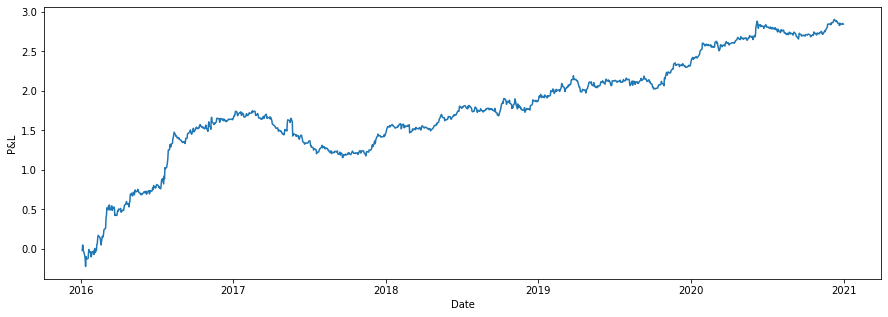

In [76]:
pl = backtest(predicted_results, expected_ret=0.1, delta_t=300)

In [77]:
backtest_evaluation(np.squeeze(pl.diff(1).dropna().values))

,mean daily ret,t value,p value,annualized ret,annualized vol,Sharpe ratio,Win ratio,Max drawdown
factor-mimicking portfolio,0.002279,3.275196,0.001085,0.645004,0.391461,1.647684,0.519491,0.473754


The strategy has annulized return of 60%, this is reasonable since the transcation cost, market impact and slippage will eat more than a half of our profit. Sharpe Ratio is 1.5, so it's a moderate strategy. Since we have only a week to do the alpha research without extensive EDA and backtest, this result is acceptable.